Hunter Bennett | Kupffer Strains | Glass Lab | 12 May 2021

Goal is to make heatmap of selected motif for epigenetic diversity figure in NASH paper.

In [12]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
# cluster targets
import scipy
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff, read_homer_gene_exp
from gene_expression_plots import survey_strain_amln_gene_exp, survey_strain_ccl4_gene_exp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####
mm_conv=25.4
matplotlib.rcParams['xtick.minor.size']=0
matplotlib.rcParams['ytick.minor.size']=0

## Define plotting functions

In [14]:
def heatmap(data, row_labels, col_labels,
            col_rotation=90, col_ha='center',
            x_fontsize=12, y_fontsize=12,
            ax=None, cbar=True, cbar_kw={}, cbarlabel="",
            **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """
    
    if not ax:
            ax = plt.gca()

    im = ax.imshow(data, **kwargs)

    # Create colorbar
    if cbar==True:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels,
                       rotation=col_rotation,
                       ha=col_ha,
                       fontdict={'fontsize':x_fontsize})
    ax.set_yticklabels(row_labels,
                       fontdict={'fontsize':y_fontsize})

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)

    ax.grid(b=True,
            which="minor",
            color='k',
            linestyle='-',
            linewidth=1)
    
def motif_score_barh(data, groups, group_labels, colors, width=0.5, spacing=0.0, relative=False, ax=None):
    '''This function allows for visualization of expression in qPCR style
    bar plots for multiple genes contained in an rpkm data file.
    
        Accepts:
            genes (str): list of geneIDs to plot
            data (pandas DataFrame): dataset in gene x sample format with geneIDs as index
            groups (int): groups of samples in the columns of data
            group_labels (str): labels of each group in groups
            colors (str) = colors of each group in groups
            width (float) = width of bars to plot, default 0.5
            spacing (float) = extra spacing between bars to plot, default 0.0
            relative (bool) = whether to standardize plot so that first group mean is 1,
            ax (matplotlib.Axes object) = plot axis
        
        Returns:
            ax (matplotlib.Axes object) = gene list bar plot'''

    import pandas as pd
    import matplotlib.pyplot as plt    
    import numpy as np
    
    # flatten scores
    scores=[]
    for (group, label) in zip(groups, group_labels):
            scores.append(data.iloc[:, group])

    # set axis
    if ax==None:
        ax = plt.gca()
        
    # plot
    ind = np.arange(data.shape[0])

    i = 0
    for score, group, label, color in zip(scores, groups, group_labels, colors):
        ax.barh(ind + (width+spacing)*i,
               score,
               width,
               color=color,
               # yerr=[np.zeros(len(std)), std],
               edgecolor='k',
               linewidth=1,
               # capsize=20,
               # error_kw={'elinewidth':2,
               #           'capthick':2,
               #           'capsize':5},
               label=label)
        i+=1

    ax.set_yticks(ind + width / 2);
    ax.set_yticklabels(data.index);
    ax.legend(fontsize=6, loc='lower right');
    # ax.set_ylabel(title)
    
    return ax


In [15]:
atacDirectory = '/home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/'
h3k27acDirectory = '/home/h1bennet/strains/results/06b_Strains_Control_Combined_H3K27Ac/'
rnaDirectory = '/home/ttroutman/strainsKupffer/rnaKupfferHealthyYoung_20210111/'
workingDirectory = '/home/h1bennet/strains_manuscript/results/04_Strains_Manuscript_Prep_Figure04_NicheNet/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

In [16]:
tfs = ['Cdx2',
       'Creb1', 'Creb3', 'Creb3l1', 'Creb3l2', 'Creb3l3', 'Creb3l4',
       'Creb5', 'Crebl2', 'Crebzf',
       'Fos', 'Fosb', 'Fosl1', 'Fosl2', 'Jun', 'Junb', 'Jund',
       'Hnf1a',
       'Hnf4a',
       'Myc', 'Mycl', 'Mycn', 'Mycs',
       'Nfkb1','Nfkb2','Rel','Rela', 'Relb', 
       'Notch1', 'Notch2', 'Notch3', 'Notch4',
       'Nr1h3', 'Ppara', 'Ppard', 'Pparg', 'Rora', 'Vdr',
       'Srebf1', 'Srebf2',
       'Runx1', 'Runx2', 'Runx3',
       'Sp1',
       'Spi1',
#        'Smad1', 'Smad2', 'Smad3', 'Smad4', 'Smad5', 'Smad6', 'Smad7', 'Smad9',

#        'Stat1', 'Stat2', 'Stat3', 'Stat4', 'Stat5a', 'Stat5b', 'Stat6'
      ]

In [17]:
motif_list = [
    # cdx
    # 'Cdx2(Homeobox)/mES-Cdx2-ChIP-Seq(GSE14586)/Homer',
    # cre reponse binding element
    'CRE(bZIP)/Promoter/Homer',
    #AP-1 family
    'Fosl2(bZIP)/3T3L1-Fosl2-ChIP-Seq(GSE56872)/Homer',
    'Jun-AP1(bZIP)/K562-cJun-ChIP-Seq(GSE31477)/Homer',
    'c-Jun-CRE(bZIP)/K562-cJun-ChIP-Seq(GSE31477)/Homer',
    'JunB(bZIP)/DendriticCells-Junb-ChIP-Seq(GSE36099)/Homer',
    'JunD(bZIP)/K562-JunD-ChIP-Seq/Homer',
    # HNFs
    'Hnf1(Homeobox)/Liver-Foxa2-Chip-Seq(GSE25694)/Homer',
    'HNF4a(NR),DR1/HepG2-HNF4a-ChIP-Seq(GSE25021)/Homer',
    # Myc
    # 'c-Myc(bHLH)/LNCAP-cMyc-ChIP-Seq(Unpublished)/Homer',
    'c-Myc(bHLH)/mES-cMyc-ChIP-Seq(GSE11431)/Homer',
    # Nfkb
    'NFkB-p65(RHD)/GM12787-p65-ChIP-Seq(GSE19485)/Homer',
    # 'NFkB-p65-Rel(RHD)/ThioMac-LPS-Expression(GSE23622)/Homer',
    'NFkB-p50,p52(RHD)/Monocyte-p50-ChIP-Chip(Schreiber_et_al.)/Homer',
    # RBPJ
    'Rbpj1(?)/Panc1-Rbpj1-ChIP-Seq(GSE47459)/Homer',
    # Nuclear Receptors
    'LXRE(NR),DR4/RAW-LXRb.biotin-ChIP-Seq(GSE21512)/Homer',
    'PPARa(NR),DR1/Liver-Ppara-ChIP-Seq(GSE47954)/Homer',
    'RORa(NR)/Liver-Rora-ChIP-Seq(GSE101115)/Homer',
    'VDR(NR),DR3/GM10855-VDR+vitD-ChIP-Seq(GSE22484)/Homer',
    # SREBP
    'Srebp1a(bHLH)/HepG2-Srebp1a-ChIP-Seq(GSE31477)/Homer',
    'Srebp2(bHLH)/HepG2-Srebp2-ChIP-Seq(GSE31477)/Homer',
    # RUNX
    'RUNX(Runt)/HPC7-Runx1-ChIP-Seq(GSE22178)/Homer',
    'RUNX1(Runt)/Jurkat-RUNX1-ChIP-Seq(GSE29180)/Homer',
    #SP1
    'Sp1(Zf)/Promoter/Homer',
    # PU1
    'PU.1(ETS)/ThioMac-PU.1-ChIP-Seq(GSE21512)/Homer',
#     # SMAD
#     'Smad2(MAD)/ES-SMAD2-ChIP-Seq(GSE29422)/Homer',
#     'Smad3(MAD)/NPC-Smad3-ChIP-Seq(GSE36673)/Homer',
#     'Smad4(MAD)/ESC-SMAD4-ChIP-Seq(GSE29422)/Homer',
#     # STAT
#     'STAT1(Stat)/HelaS3-STAT1-ChIP-Seq(GSE12782)/Homer',
#     'Stat3(Stat)/mES-Stat3-ChIP-Seq(GSE11431)/Homer',
#     'Stat3+il21(Stat)/CD4-Stat3-ChIP-Seq(GSE19198)/Homer',
#     'STAT4(Stat)/CD4-Stat4-ChIP-Seq(GSE22104)/Homer',
#     'STAT5(Stat)/mCD4+-Stat5-ChIP-Seq(GSE12346)/Homer',
#     'STAT6(Stat)/Macrophage-Stat6-ChIP-Seq(GSE38377)/Homer',
#     'STAT6(Stat)/CD4-Stat6-ChIP-Seq(GSE22104)/Homer'
]

### Read in RNA-seq data

In [18]:
tpm = read_homer_gene_exp(rnaDirectory+'/rnaQuan/HOMER.rawTPM.txt',
                          gene_name_index=True)

tpm_mat = pd.read_csv(rnaDirectory+'/rnaQuan/rawT.txt',
                      sep='\t',
                      index_col=0)

In [19]:
avg_tpm_df = pd.read_csv(
    '/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA/hepatic_cells_average_tpm.txt',
    sep='\t',
    index_col=0)

avg_tpm_df = avg_tpm_df.loc[:, avg_tpm_df.columns.str.contains('kupffer')]

# Z-scored expression

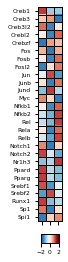

In [20]:
# select ligand subset
f = avg_tpm_df.replace(np.nan, 0).loc[tfs, ]

# filter ligands with TPM < 5 in all samples.
f = f.loc[(f > 5).any(1), :]

# z-score by ligand
sd = np.std(f, 1)
mean = np.mean(f, 1)
z_frame = f.subtract(mean, axis='rows').divide(sd, axis='rows')
# z_frame.columns = z_frame.columns.str.split('_').str[0]

# # calculate clustering
# d2 = dist.pdist(z_frame)
# D2 = dist.squareform(d2)
# Y2 = sch.linkage(D2, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
# Z2 = sch.dendrogram(Y2, no_plot=True)
# heatmap(z_frame.iloc[Z2['leaves'], :],
#         row_labels = [z_frame.index[i] for i in Z2['leaves']],

fig, ax = plt.subplots(figsize=(80/mm_conv, 125/mm_conv))
heatmap(z_frame,
        row_labels = z_frame.index,
        col_labels = '',
        vmin=-2,
        vmax=2,
        cmap='RdBu_r',
        cbar=True,
        x_fontsize=6,
        y_fontsize=6,
        cbar_kw={'orientation':'horizontal',
                 'pad':0.05,
                 'shrink':0.1,
                 'aspect':2},
        ax=ax)

plt.savefig('./tf_expression_zscore_tpm.pdf',
            bbox_inches='tight')

# Log TPM Experssion

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

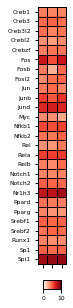

In [22]:
# select ligand subset
f = avg_tpm_df.replace(np.nan, 0).loc[tfs, ]

# filter ligands with TPM < 5 in all samples.
f = f.loc[(f > 5).any(1), :]

# calculate clustering
# d2 = dist.pdist(f)
# D2 = dist.squareform(d2)
# Y2 = sch.linkage(D2, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
# Z2 = sch.dendrogram(Y2, no_plot=True)

fig, ax = plt.subplots(figsize=(80/mm_conv, 150/mm_conv))
heatmap(np.log2(f),
        row_labels = f.index,
        col_labels = '',
        vmin=0,
        vmax=10,
        cmap='Reds',
        cbar=True,
        x_fontsize=6,
        y_fontsize=6,
        cbar_kw={'orientation':'horizontal',
                 'pad':0.05,
                 'shrink':0.1,
                 'aspect':2},
        ax=ax)

plt.savefig('./tf_expression_log_tpm.pdf',
            bbox_inches='tight')

### Make directory for heatmap

In [23]:
if not os.path.isdir('./nichenet_motif_heatmap/'):
    os.mkdir('./nichenet_motif_heatmap/')

# Aggregate results - Homer

In [24]:
known_motif_pval_frame = pd.read_csv(atacDirectory+'/homer_known_motifs_differential_log.txt', sep='\t', index_col=0)

# Plot known motif results

## Option for future: set custom motif list

In [25]:
# we will make this plot using 'union' differential enhancer set
# we will also use all enhancers to raise our power.

tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('union')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('distal')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('nobg_nodenovo')]
tmp_frame = tmp_frame.loc[motif_list, :]

#clean up rows for tmp frame
tmp_frame.index = tmp_frame.index.str.split('/').str[0]

# convert to log10 p value
tmp_frame = np.log10(np.e**(tmp_frame))

# clean up columns
tmp_frame.columns = ['A/J', 'BALB/cJ', 'C57BL/6J']

tmp_frame_log10 = -np.log10(np.e**(tmp_frame))


In [26]:
palette = {'A/J':"#e41a1c", 'BALB/cJ':"#377eb8", 'C57BL/6J':"#4daf4a"}
mm_conv = 25.4

Can we display as horizontal bar plots?

(0, 22)

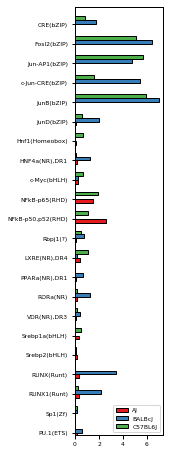

In [27]:
fig, ax = plt.subplots(figsize=(40/mm_conv, 200/mm_conv))
motif_score_barh(tmp_frame_log10.iloc[::-1],
                 groups=[0,1,2],
                 width=0.2,
                 group_labels=['AJ', 'BALBcJ', 'C57BL6J'],
                 colors=[palette['A/J'], palette['BALB/cJ'], palette['C57BL/6J']],
                 ax=ax)

ax.set_ylim([0, tmp_frame_log10.shape[0]])

# Combined Plot

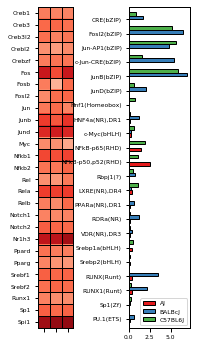

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(75/mm_conv, 150/mm_conv))
plt.subplots_adjust(wspace=0.7)
# select ligand subset
f = avg_tpm_df.replace(np.nan, 0).loc[tfs, ]

# filter ligands with TPM < 5 in all samples.
f = f.loc[(f > 5).any(1), :]

heatmap(np.log2(f),
        row_labels = f.index,
        col_labels = '',
        vmin=0,
        vmax=10,
        cmap='Reds',
        cbar=False,
        x_fontsize=6,
        y_fontsize=6,
#         cbar_kw={'orientation':'horizontal',
#                  'pad':0.01,
#                  'shrink':0.1,
#                  'aspect':2,
#                   frac},
        ax=ax1)

motif_score_barh(tmp_frame_log10.iloc[::-1],
                 groups=[0,1,2],
                 width=0.25,
                 group_labels=['AJ', 'BALBcJ', 'C57BL6J'],
                 colors=[palette['A/J'], palette['BALB/cJ'], palette['C57BL/6J']],
                 ax=ax2)

# ax2.invert_yaxis()


ax2.set_ylim([-0.5, tmp_frame_log10.shape[0]])

plt.savefig('./tf_expression_motif_score.pdf',
            bbox_inches='tight')

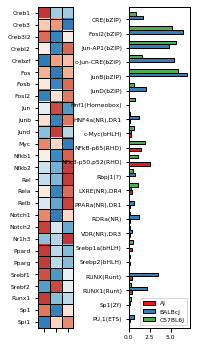

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(75/mm_conv, 150/mm_conv))
plt.subplots_adjust(wspace=0.7)
# select ligand subset
f = avg_tpm_df.replace(np.nan, 0).loc[tfs, ]

# filter ligands with TPM < 5 in all samples.
f = f.loc[(f > 5).any(1), :]

sd = np.std(f, 1)
mean = np.mean(f, 1)
z_frame = f.subtract(mean, axis='rows').divide(sd, axis='rows')

heatmap(z_frame,
        row_labels = z_frame.index,
        col_labels = '',
        vmin=-2,
        vmax=2,
        cmap='RdBu_r',
        cbar=False,
        x_fontsize=6,
        y_fontsize=6,
#         cbar_kw={'orientation':'horizontal',
#                  'pad':0.01,
#                  'shrink':0.1,
#                  'aspect':2,
#                   frac},
        ax=ax1)

motif_score_barh(tmp_frame_log10.iloc[::-1],
                 groups=[0,1,2],
                 width=0.25,
                 group_labels=['AJ', 'BALBcJ', 'C57BL6J'],
                 colors=[palette['A/J'], palette['BALB/cJ'], palette['C57BL/6J']],
                 ax=ax2)

ax2.set_ylim([-0.5, tmp_frame_log10.shape[0]])

plt.savefig('./tf_zscale_expression_motif_score.pdf',
            bbox_inches='tight')

### Make colorbar

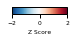

In [31]:
fig, ax = plt.subplots(figsize=(1,1))

cmap = matplotlib.cm.RdBu_r
norm = matplotlib.colors.Normalize(vmin=-2, vmax=2)
plt.gca().set_visible(False)
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm,  cmap=cmap),
                  use_gridspec=True,
                  orientation='horizontal',
                  label='Z Score',
                  aspect=8)
plt.savefig('./colorbar.pdf',
            bbox_inches='tight')

# Old plots

In [ ]:
# set plot size
fig, ax = plt.subplots(figsize=(40/mm_conv, 150/mm_conv))

# convert to a log2 frame
# tmp_frame = np.log10(np.e**(tmp_frame))

cm = sns.heatmap(
    -np.log10(np.e**(tmp_frame)),
    cmap='Purples',
    linewidths=1,
    linecolor='k',
    vmax=6,
    # annot=True,
    square=True,
    cbar_kws={'label': '-log10(pval)'},
    ax=ax)
    #square=True)

# plt.savefig('./atac_known_motif_heatmap/homer_enrichedmotifs_custommotifs_intersection_enhancers.pdf',
#             bbox_inches='tight')

In [ ]:
tmp_frame_log10 = -np.log10(np.e**(tmp_frame))

tmp_frame_melt = tmp_frame_log10.reset_index().melt(id_vars='index',
                             var_name='strain',
                             value_name='motif score')

# make motif score positive
# tmp_frame_melt['motif score'] = -tmp_frame_melt['motif score']

# simplify column names
tmp_frame_melt['index'] = tmp_frame_melt['index'].str.split('/').str[0]